In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ta as ta
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler

## Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
## Import
data = pd.read_csv('Binance_BTCUSDT_1h.csv')

## special function for date
def treat_date(date):
    if 'AM' in date or 'PM' in date:
        return date[:-3] +':00'
    else:
        return date[:-3]

## Apply function for date
data['date'] = data['date'].apply(treat_date)
data = data[::-1].reset_index().drop(['unix', 'symbol', 'index', 'tradecount', 'date', 'Volume BTC'], axis=1)

def import_and_treat_data(train_test_split, data, scale):
    ## Length
    N = data.shape[0]
    
    ## Scaling
    if scale:
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)
    
    ## Train/Test split
    training_data, test_data = data[:int((1-train_test_split)*N)].copy(), data[int((1-train_test_split)*N):].copy()
    
    return training_data, test_data

In [3]:
training_data, test_data = import_and_treat_data(0.2, data, False)

In [4]:
training_data.shape, test_data.shape

((31955, 5), (7989, 5))

In [5]:
X_train, y_train = training_data.iloc[:-1, 3], training_data.iloc[1:, 3]

In [6]:
X_test, y_test = test_data.iloc[:-1, 3], test_data.iloc[1:, 3]

In [7]:
X_train.shape, y_train.shape

((31954,), (31954,))

In [8]:
X_test.shape, y_test.shape

((7988,), (7988,))

In [9]:
data = {
    'Y_lag_1': X_train
}

df_train = pd.DataFrame( data)

In [10]:
data = {
    'Y_lag_1': X_test
}

df_test = pd.DataFrame( data)

In [11]:
df_train['EMA_10'] = ta.trend.ema_indicator(X_train, window=10)

In [12]:
df_train['EMA_20'] = ta.trend.ema_indicator(X_train, window=20)

In [13]:
df_test['EMA_10'] = ta.trend.ema_indicator(X_test, window=10)
df_test['EMA_20'] = ta.trend.ema_indicator(X_test, window=20)

In [14]:
df_train = df_train.dropna()

In [15]:
df_test = df_test.dropna()

In [16]:
def signal(row):
    if row[0] >= row[1]:
        return 1
    else:
        return -1

In [17]:
df_train['trend'] = df_train[['EMA_10', 'EMA_20']].apply(signal, axis=1)

In [18]:
df_test['trend'] = df_test[['EMA_10', 'EMA_20']].apply(signal, axis=1)

In [19]:
df_train['Y_t'] = y_train[19:].values

In [20]:
df_test['Y_t'] = y_test[19:].values

## Baseline

$$Y_t = \alpha Y_{t-1} + \beta X_{trend}$$

In [21]:
cols = ['Y_t', 'Y_lag_1', 'trend']

model = smf.ols(formula = 'Y_t ~ Y_lag_1 + trend - 1', data = df_train).fit()

print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    Y_t   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.771e+08
Date:                Tue, 30 Nov 2021   Prob (F-statistic):                        0.00
Time:                        19:18:57   Log-Likelihood:                     -1.8853e+05
No. Observations:               31935   AIC:                                  3.771e+05
Df Residuals:                   31933   BIC:                                  3.771e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [22]:
# Compute Out-of-sample R-squared using the test set

def OSR2(model, df_train, df_test, dependent_var):   
    
    y_test = df_test[dependent_var]
    y_pred = model.predict(df_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(df_train[dependent_var]))**2)    
    
    return 1 - SSE/SST

In [23]:
OSR2(model, df_train, df_test, 'Y_t')

0.9998893686263647

In [24]:
print('MSE train :', mean_squared_error(model.predict(df_train), df_train.Y_t))
print('MAE train :', mean_absolute_error(model.predict(df_train), df_train.Y_t))

MSE train : 7857.476748562032
MAE train : 42.88903366776468


In [25]:
print('MSE test :', mean_squared_error(model.predict(df_test), df_test.Y_t))
print('MAE test :', mean_absolute_error(model.predict(df_test), df_test.Y_t))

MSE test : 167767.91477690343
MAE test : 280.0867607030413


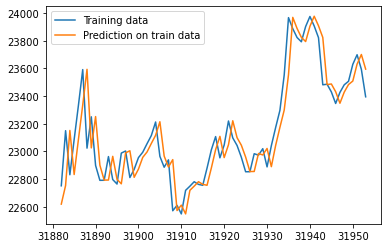

In [26]:
from matplotlib import pyplot as plt

zoom = 3

df_train_plot = df_train[-zoom*24:]
df_test_plot = df_test[:zoom*24]

y_pred = model.predict(df_train_plot)

plt.plot(df_train_plot.index, df_train_plot.Y_t, label = 'Training data')
plt.plot(df_train_plot.index, y_pred, '-' , label = 'Prediction on train data')

plt.legend()
plt.show()

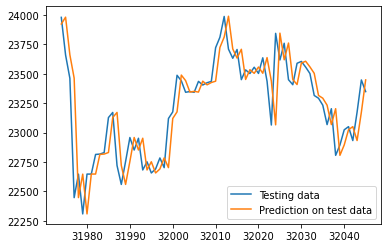

In [27]:
y_pred_test = model.predict(df_test_plot)

plt.plot(df_test_plot.index, df_test_plot.Y_t, label = 'Testing data')
plt.plot(df_test_plot.index, y_pred_test, '-' , label = 'Prediction on test data')

plt.legend()
plt.show()

## Backtester

- if $\hat Y_t > (1+\alpha) Y_{t-1}$ --> long
- if $\hat Y_t < (1-\alpha) Y_{t-1}$ --> short
- if $|\hat Y_t - Y_{t-1}| < \alpha $ --> neutral

(array([2.000e+00, 1.000e+00, 1.700e+01, 1.040e+02, 5.101e+03, 2.648e+04,
        2.030e+02, 1.900e+01, 5.000e+00, 3.000e+00]),
 array([-0.18211473, -0.14651927, -0.11092381, -0.07532835, -0.03973288,
        -0.00413742,  0.03145804,  0.0670535 ,  0.10264896,  0.13824443,
         0.17383989]),
 <BarContainer object of 10 artists>)

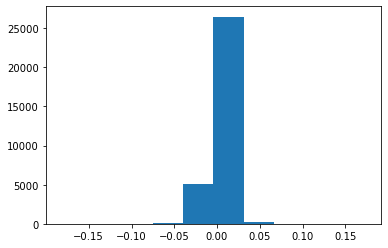

In [29]:
## alpha

alphas = (df_train.Y_t - df_train.Y_lag_1)/df_train.Y_lag_1

plt.hist(alphas)

In [30]:
alpha = 0.00005

In [31]:
def backtest(df_test, model):
    y_pred = model.predict(df_test)
    
    close_t = df_test['Y_t']
    close_lag_1 = df_test['Y_lag_1']
    
    signal = []

    for i, pred in enumerate(y_pred):
        #print('\nTime', str(i))
        #print('pred', y_pred.iloc[i] > (1+alpha)*close_lag_1.iloc[i])
        
        if y_pred.iloc[i] >= (1+alpha)*close_lag_1.iloc[i]:
            #print('pred', y_pred.iloc[i], 'y_{t-1}', close_lag_1.iloc[i])
            #print('long')
            signal.append(1)
            
        elif y_pred.iloc[i] <= (1-alpha)*close_lag_1.iloc[i]:
            #print('pred', y_pred.iloc[i], 'y_{t-1}', close_lag_1.iloc[i])
            #print('short')
            signal.append(-1)
        
        else:
            #print('pred', y_pred.iloc[i], 'y_{t-1}', close_lag_1.iloc[i])
            #print('neutral')
            signal.append(0)

    return signal

In [32]:
signal = backtest(df_test, model)
signal = pd.DataFrame(signal)

In [33]:
def strat(signals, close, verbose=False):
    XRP = [0]
    USD = [500]
    value = [500]
    R = [1]
    pos = [0]
    long_times = []
    short_times = []
    exit_times = []
    longs = []
    shorts = []
    exits = []
    
    current_pos = {
        "side": 0,
        "qty": 1,
        "take_profit": 0.5,
        "stop_loss": -0.2,
        "entry_price": 0,
        "exit_price": 0,
        "entry_time": 0,
        "exit_time": 0,
        "exit_reason": ""
    }
    trades = []
    
    def enter_long(i):
        XRP.append(USD[i]*0.999/close[i])
        USD.append(0)
        pos.append(1)
        long_times.append(signals.index[i])
        longs.append(close[i])
        current_pos['side'] = 1
        current_pos['entry_price'] = close[i]
        current_pos['entry_time'] = signals.index[i]
    
    def enter_short(i):
        XRP.append(USD[i]*0.999/close[i])
        USD.append(0)
        pos.append(-1)
        short_times.append(signals.index[i])
        shorts.append(close[i])
        current_pos['side'] = -1
        current_pos['entry_price'] = close[i]
        current_pos['entry_time'] = signals.index[i]
        
    def neutral(i):
        XRP.append(XRP[i])
        USD.append(USD[i])
        pos.append(0)
        
    def exit(i, why, side, ROI):
        XRP.append(0)
        pos.append(0)
        exit_times.append(signals.index[i])
        exits.append(close[i])
        
        if side == 1:
            USD.append(0.999 * XRP[i] * current_pos["entry_price"] * (1+ROI/100) )
            current_pos['exit_price'] = close[i]
            current_pos["exit_time"] = signals.index[i]
            current_pos["exit_reason"] = why
            trades.append(current_pos.copy())
            
        if side == -1:
            USD.append(0.999 * XRP[i] * current_pos["entry_price"] * (1+ROI/100) )
            current_pos['exit_price'] = close[i]
            current_pos["exit_time"] = signals.index[i]
            current_pos["exit_reason"] = why
            trades.append(current_pos.copy())
    
    def monitor_exit(i):
        if pos[i] == 1:
            ROI = (close[i] - current_pos["entry_price"])*100/current_pos["entry_price"]
            if verbose:
                print("ROI", ROI)
            if ROI > 0.5:
                exit(i, "take_profit", 1, ROI)
            elif ROI < -0.2:
                exit(i, "stop_loss", 1, ROI)
            else:
                XRP.append(XRP[i])
                USD.append(USD[i])
                pos.append(1)
            
        if pos[i] == -1:
            ROI = -(close[i] - current_pos["entry_price"])*100/current_pos["entry_price"]
            if verbose:
                print("ROI", ROI)
            if ROI > 0.5:
                exit(i, "take_profit", -1, ROI)
            elif ROI < -0.2:
                exit(i, "stop_loss", -1, ROI)
            else:
                XRP.append(XRP[i])
                USD.append(USD[i])
                pos.append(-1)
    
    for i, s in enumerate(signals):
        print(i)
        if pos[i] == 0:
            if verbose:
                print("\nnot in position, " + str(i))
            ## long signal, enter long
            if s == 1:
                if verbose:
                    print("enter long")
                enter_long(i)

            ## short signal, enter short
            if s == -1:
                if verbose:
                    print("enter short")
                enter_short(i)

            ## stay neutral
            if s == 0:
                if verbose:
                    print("stay neutral")
                neutral(i)
        
        if pos[i] != 0 :
            if verbose:
                print("\nin position, " + str(i))
                print(current_pos)
            ## monitor return
            monitor_exit(i)
        
        if verbose:
            print("close", close[i])
            print("USD", USD[i])
            print("XRP", XRP[i])
    
    return XRP, USD, pos, long_times, short_times, exit_times, longs, shorts, exits, trades

In [34]:
strat(signal, df_test.Y_t.values, verbose=True)

0

not in position, 0
stay neutral
close 23980.0
USD 500
XRP 0


([0, 0], [500, 500], [0, 0], [], [], [], [], [], [], [])

In [35]:
signal

,0
0,1
1,1
2,1
3,1
4,0
...,...
7964,0
7965,0
7966,0
7967,0
